In [147]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [148]:
param_names=['signal','pl_fr','real_wf-pl_fr','mask']

In [108]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print(max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params
def renormin(data_not_change,norm_params,param_names=param_names,log=True):
    data=np.copy(data_not_change)
    for i in range(data.shape[-1]):
        max_c, min_c=norm_params[param_names[i]]
        data[:,:,:,i]=data[:,:,:,i]*(max_c-min_c) + min_c
        if (i==0 and log):
            data[:,:,:,i]=tf.math.exp(data[:,:,:,i])-1
        elif (i==1 or i==2):
            data[:,:,:,i]=data[:,:,:,i]*1e6
    return data

In [112]:
path='../../mc_hadrons_qgs34_0010.h5'
data_name='pr-q4-9yr'
data=np.zeros((0,6,6,4))
with h5py.File(path,'r') as f:
    print(f[data_name]['dt'].shape)
    data=np.concatenate((data,f[data_name]['dt'][:2000,:,:,3:7]))
    gp=f[data_name]['gp'][()]
    ev_params=f[data_name]['ev_params'][()]
# data=data[1:]
data[:,:,:,1]=data[:,:,:,1]*1e6
data[:,:,:,2]=data[:,:,:,2]*1e6
print('len data: ',len(data))

(268322, 6, 6, 7)
len data:  2000


In [188]:
# new data
path='../../data_01_24.h5'
num_ev=2000
with h5py.File(path,'r') as f:
    data=f['dt_bunlde'][:num_ev,:,:,3:7]
    ev_params = f['recos'][:num_ev,:2]
    real_ang = f['mc_params'][:num_ev,4:6]

# Constant

In [114]:
pi = tf.constant(math.pi)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=30e-3
LINSLEY_r0=0.025
Det_Area=30
tf_type=tf.float32
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])
t_err_res=c/1e6
t0_err=30

In [115]:
def reduce_saturation(data,ret_sig=True):
    max_signal=tf.reduce_max(data[:,:,:,0])
    signal=data[:,:,:,0]
    mask=data[:,:,:,3]
#     print('old signal \n',signal)
#     print('old mask \n',mask)
    new_mask=tf.where(tf.logical_and(mask!=0,signal==0),0,mask)
    new_signal=tf.where(tf.logical_and(mask!=0,signal==0),max_signal,signal)
    res=tf.where(tf.logical_and(mask!=0,signal==0),1,0)
    print(tf.reduce_sum(res))
    if ret_sig:
        return new_signal
    else:
        return new_mask

In [283]:
pi = tf.constant(math.pi)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=30e-3
LINSLEY_r0=0.025
Det_Area=30
tf_type=tf.float32
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])
t_err_res=c/1e6
t0_err=30
class Reconstruction():
    #constants
    pi = tf.constant(math.pi)
    UNIT=1
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    c=tf.constant(299792.458,dtype=tf.float32)# # km\s
    NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
    R_L=30e-3
    LINSLEY_r0=0.025
    DET_AREA=3
    s_min = tf.constant([[0.3]])
    s_max = tf.constant([[1.8]])
    t_err_res=c/1e6
    t0_err=30
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    
    def __init__(self,data,tf_type):
        # all have shape (batch,6,6,1)
        self.tf_type = tf_type
        self.data=tf.cast(data,self.tf_type)
        self.mask = tf.expand_dims(data[:,:,:,3],-1)
        self.signal = tf.expand_dims(data[:,:,:,0],-1)*self.mask
        self.mask = tf.where(self.signal==0,0,self.mask)
        self.real_time = tf.expand_dims((data[:,:,:,1] + data[:,:,:,2]),-1)*self.mask 
        self.signal = tf.cast(self.signal,self.tf_type)
        self.real_time = tf.cast(self.real_time,self.tf_type)
        self.mask = tf.cast(self.mask,self.tf_type)
        self.batch = data.shape[0]
        self.t0 = None
        self.theta = None
        self.detertors_coord = None
        self.core = None
        self.t_place = None
        self.courve = None
        self.R_error = 0.15
        self.S_X=None
        self.LDF=None
#     @classmethod
    def detectors_init(self):
        x = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),self.tf_type)
        y = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),self.tf_type)
        x = tf.expand_dims(x,-1)
        y = tf.expand_dims(y,-1)
        # x.shape = (6,6,1)
        detectors = tf.concat([x,y],axis=-1) * self.dist
        
        #detectors.shape = (batch,6,6,2) in km
        detectors = tf.repeat(tf.expand_dims(detectors,0),self.batch,0)
        self.detertors_coord=detectors
        return detectors
#     @classmethod
    def core_(self):
        detectors = self.detectors_init() # shape (batch,6,6,2)
        sum_signal=tf.reduce_sum(self.signal,axis=(1,2)) # shape (batch ,1)
        core=tf.reduce_sum(detectors * self.signal, axis=(1,2))/sum_signal
        #update self
        self.core = core
        return core
    @staticmethod
    def expand_dims(vec):
        return tf.expand_dims(tf.expand_dims(vec,-1),-1)
    def create_matrix(self,x,y,t,mask):
        a11=self.expand_dims(tf.reduce_sum(x*x,axis=1))
        a12=self.expand_dims(tf.reduce_sum(x*y,axis=1))
        a13=self.expand_dims(tf.reduce_sum(x,axis=1))
        a22=self.expand_dims(tf.reduce_sum(y*y,axis=1))
        a23=self.expand_dims(tf.reduce_sum(y,axis=1))
        a33=self.expand_dims(tf.reduce_sum(mask,axis=1))
        a1=tf.concat([a11,a12,a13],axis=2)
        a2=tf.concat([a12,a22,a23],axis=2)
        a3=tf.concat([a13,a23,a33],axis=2)
        A=tf.concat([a1,a2,a3],axis=1)

        b1=self.expand_dims(tf.reduce_sum(x*t,axis=1))
        b2=self.expand_dims(tf.reduce_sum(y*t,axis=1))
        b3=self.expand_dims(tf.reduce_sum(t,axis=1))
        b=tf.concat([b1,b2,b3],axis=1)
        return A,b
    def place_sol(self):
        real_time=self.real_time
        mask=self.mask
        detectors = self.detectors_init() * mask
        x = tf.reshape(detectors[:,:,:,0],(-1,36))
        y = tf.reshape(detectors[:,:,:,1],(-1,36))
        t = tf.reshape(real_time,(-1,36))
        mask = tf.reshape(mask,(-1,36))
        A,b=self.create_matrix(x,y,t,mask)
        return tf.linalg.solve(A,b)
#     @classmethod
    def place_params(self):
        sol = self.place_sol()
        #t_0=b+(r_cor;n)
        b=sol[:,2:,0]
        n=sol[:,:2,0]
        core = self.core_()
        mul=n[:,0]*core[:,0]+n[:,1]*core[:,1]
#         t0 = tf.cast(tf.expand_dims(b,1)+tf.expand_dims(mul,1),dtype=self.tf_type)
        t0=b
        a_x=n[:,0]
        a_y=n[:,1]
        a_z=tf.math.pow(1e6/c,2) - (tf.math.pow(a_x,2) + tf.math.pow(a_y,2))
        a_z=tf.where(a_z>0,tf.math.sqrt(a_z),0)
        cos_theta=a_z*(c/1e6)
        theta=tf.math.acos(cos_theta)
        tg_phi=a_x/(-a_y)
        atan=tf.math.atan(tg_phi)
        phi=tf.where(a_y>0,atan+pi,atan-pi)
        phi=tf.where(a_x<0,atan,phi)
        phi = tf.math.atan2( -a_x, -a_y )
        # update self
        self.phi = phi
        self.theta = theta
        self.t0=t0
        return t0,tf.expand_dims(theta,-1),tf.expand_dims(phi,-1)
    def detectors_core(self):
        detectors=self.detertors_coord
        core = self.core
        detectors_c=detectors-tf.reshape(core,(-1,1,1,2))
        return detectors_c
    def detectors_core_static(self,core):
        detectors=self.detertors_coord
#         core = self.core
        detectors_c=detectors-tf.reshape(core,(-1,1,1,2))
        return detectors_c
#     @classmethod
    def place_reconstruction(self):
        t0,theta,phi = self.place_params()
        detectors = self.detectors_core()
        detectors = self.detertors_coord
#         print(detectors)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    def place_reconstruction_static(self,t0,theta,phi,core):
        detectors = self.detectors_core_static(core)
#         detectors = self.detertors_coord
#         print(detectors)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    @staticmethod
    def eta_fun(theta):
        x=theta*180/3.14

        e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
        e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
                   + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
                 + 3.70692527e+00)
        res = tf.where(x<62.7,e1,e2)
        # check
        res =tf.where(res>0,res,0)
        return res
    def s_profile_tasimple(self,r_ta,theta):
        r = r_ta*UNIT
        eta=self.eta_fun(theta)# batch,1,1
        eta=tf.repeat(eta,6,axis=1)
        eta=tf.repeat(eta,6,axis=2)
        # eta shape is batch,6,6
        Rm = tf.constant(0.09,dtype=tf.float32)
        R1 = tf.constant(1,dtype=tf.float32)
        return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))
    def s_profile(self,r_ta, theta):
        #r_ta shape batch,6,6
        f800=self.s_profile_tasimple(self.expand_dims(tf.constant(0.8)), theta)
        return self.s_profile_tasimple(r_ta, theta)/f800
    def pfs__pps(self):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2] # not has t0
        # end t_place's part
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),self.mask,0.),tf_type)
        pfs = tf.reduce_sum(self.signal*cond_dist,axis=(1,2))
        pps = tf.reduce_sum(self.s_profile(dist_core,theta)*cond_dist,axis=(1,2))
        # might update self
        return (pfs,pps)
    @staticmethod
    def a_ivanov_fun(theta):
        DEG=pi/180
        threshold1=25*DEG
        threshold2=35*DEG
        # переписать для обнавления масива
        res1=tf.where(theta<threshold1,3.3836 - 0.01848*theta/DEG,0)
        res3=tf.where(theta>threshold2,tf.math.exp(-3.2e-2*theta/DEG + 2.0),0)
        a=(0.6511268210e-4*(theta/DEG-0.2614963683))*(theta/DEG*theta/DEG-134.7902422*theta/DEG+4558.524091)
        res2=tf.where(tf.math.logical_and(theta > threshold1,theta < threshold2),a,0)
        return res1+res2+res3
    
    def courve_fun(self):
        a_ivanov = self.a_ivanov_fun(self.theta)
        pfs,pps = self.pfs__pps()
        # norming
        S_X = tf.where(pps>1e-10,pfs/pps,1)[:,0]
        self.S_X=tf.expand_dims(S_X,-1)
        courve = tf.expand_dims(a_ivanov*1.3/tf.math.sqrt(S_X),axis=-1)
        self.courve = courve
        return courve
    @staticmethod
    def linsley_t(r,S):
        return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)/1e3
    def courve_reconstruction(self):
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        LDF=self.s_profile(dist_core,theta)
        self.LDF=LDF
        td=self.expand_dims(self.courve)*self.linsley_t(dist_core,LDF)/NSEC
        return td
    def courve_reconstruction_static(self,t0,theta,phi,courve,core):
#         t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core_static(core)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        # add R-error
        dist_core = tf.where(dist_core>self.R_error*self.R_error,tf.math.sqrt(dist_core),self.R_error)
        cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),self.mask,0.),tf_type)
        LDF=self.s_profile(dist_core,theta)
        self.LDF=LDF
        td=self.expand_dims(courve)*self.linsley_t(dist_core,LDF)/NSEC
        return td,LDF
    @staticmethod
    def logPua(n,nbar):
        print(n.shape,nbar.shape)
        last_part = 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar))

        nbar_logical=tf.where(nbar < 1e-90,True,False)
        n_logical1 = tf.where(n>1e-90,True,False)
        res = tf.zeros_like(n)
        res=tf.where(tf.logical_and(nbar_logical,n_logical1),-1e-6,res)

        else_nbar_logical = tf.logical_not(nbar_logical) 
        n_logical2 = tf.where(n<1e-20,True,False)

        res=tf.where(tf.logical_and(else_nbar_logical,n_logical2),-2*nbar,res)
        res=tf.where(tf.logical_and(else_nbar_logical,tf.logical_not(n_logical2)),last_part,res)
        return res
    def chi2L(self,S_X,s_prof):
        mask=self.mask
        s_fit = self.expand_dims(S_X)*s_prof*mask
#         print('SX',self.expand_dims(S_X),'\ns_prof',s_prof[:,:,:,0],'\n sift',s_fit[:,:,:,0])
        qs=self.signal
        s_sigma2 = ( 2*qs/self.DET_AREA + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
        maskL2 = tf.where(qs>4.0,mask,0)
        S=S_X
#         print(s_fit[:,:,:,0],qs[:,:,:,0])
        chi2L2=tf.reduce_sum((qs - s_fit)*(qs - s_fit)/s_sigma2*maskL2,axis=(1,2))
        maskL3 = tf.where(s_fit<4.0,mask,0)
#         chi2L3 = -tf.reduce_sum(0.4*self.logPua(S*self.DET_AREA, s_fit*self.DET_AREA)*maskL3,axis=(1,2))
#         print(chi2L2.shape,chi3L.shape)
        return chi2L2  #+ chi3L
    def optimization(self,iterats,alpha=0.1):
        # add ch2_L
        self.detectors_init()
        self.core_()
        self.place_sol()
        # ??? don't work without that 
        pfs,pps= rec.pfs__pps()
        rec.courve_fun()
        chi_list=[]
        self.place_params()
        t0=self.t0
        theta=tf.expand_dims(self.theta,-1)
        phi=tf.expand_dims(self.phi,-1)
        core = self.core
        courve= self.courve
        S_X = self.S_X
#         print(S_X)
        params=tf.concat([t0,theta,phi,courve,core,S_X],axis=1)
    
        
        params_list=[]
        params_list.append(params)
        for i in range(iterats):
            with tf.GradientTape() as gr:  
                gr.watch(params)
                self.t0=params[:,0:1]
                self.theta=params[:,1:2]
                self.phi=params[:,2:3]
                self.courve=params[:,3:4]
                self.core=params[:,4:6]
                self.S_X=params[:,6:7]
                
                t0=params[:,0:1]
                theta=params[:,1:2]
                phi=params[:,2:3]
                courve=params[:,3:4]
                core=params[:,4:6]
                S_X=params[:,6:7]
#                 print(i,S_X[5:7])
                t_place = self.place_reconstruction_static(t0,theta,phi,core)
                td,LDF = self.courve_reconstruction_static(t0,theta,phi,courve,core)  #update LDF <==> s_profile
                t_sigma2=(t0_err*t0_err + td*td) * t_err_res
                time_reco = t_place +td
                chi_T=tf.reduce_sum(tf.math.pow((time_reco-self.real_time)*self.mask,2)/t_sigma2,axis=(1,2))
                chi_L=self.chi2L(S_X,LDF)
                chi = chi_T +chi_L
#                 print(tf.reduce_mean(chi_T),tf.reduce_mean(chi_L),end='\r')
                chi_list.append(chi)
                grad=gr.gradient(chi,params)
#                 grad = grad* tf.constant()
                print('grad',grad[:])
                params=params-alpha*grad
                # updating
                self.t0=params[:,0:1]
                self.theta=params[:,1:2]
                self.phi=params[:,2:3]
                self.courve=params[:,3:4]
                self.core=params[:,4:]
                self.S_X=params[:,6:7]
                params_list.append(params)
        return np.array(chi_list),np.array(params_list)

In [284]:
rec = Reconstruction(data[10:110],tf.float32)
# det=rec.detectors_init()
# core=rec.core_()
# sol = rec.place_sol() 
# sol
chi,params=rec.optimization(1,alpha=0.0001)

grad tf.Tensor(
[[       0.13546038        0.0069978         0.02238973        0.03257705
        -0.17715174        0.27414858        0.        ]
 [       0.2621398         0.1516166        -1.7446506         0.11656566
        -2.4229665       -52.20805           1.3677741 ]
 [       0.2761823         1.7864158        -3.2785573         0.06329507
       -28.949923          1.3441193         1.0346364 ]
 [      -0.15413702        2.1440387         1.1704214        -0.04491044
       -17.49148         -29.770382          0.66175604]
 [       0.17194319       -3.2248402        -0.8080935         0.14487286
        22.70309         -25.39246          -0.52351695]
 [      -0.09636541        7.915969          4.576287         -0.01783617
       -44.395462       -118.550896         21.351185  ]
 [       0.1121503     -8202.677        -12007.704             0.07987715
   -429712.22           5766.019          2364.2244    ]
 [      -0.3278293        25.796928        -14.20848          -0.05

In [285]:
rec.signal[7,:,:,0]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 1.27241 , 4.17148 , 0.572084, 0.      , 0.      ],
       [0.      , 1.33466 , 0.      , 2.47954 , 0.      , 0.      ],
       [0.      , 0.      , 1.81934 , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ]],
      dtype=float32)>

In [ ]:
rec.

In [271]:
# adam 
# grad clip

In [272]:
rec.theta.shape
# data[:2000].shape

TensorShape([100, 1])

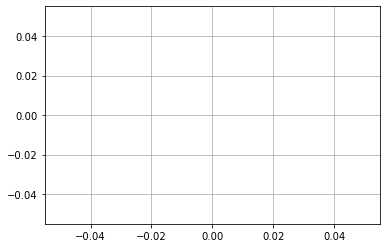

In [273]:
plt.plot(tf.reduce_mean(chi[200:,:,0],axis=1))
plt.grid()

(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)


Text(0.5, 1.0, 'chi_T')

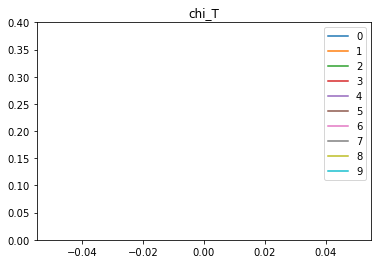

In [274]:
for i in range(10):
    print(np.array(chi).shape)
    plt.plot(chi[:,i,0],label=str(i))
    plt.ylim(0,0.4)
plt.legend()
plt.title('chi_T')

(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)


Text(0.5, 1.0, 'S_X')

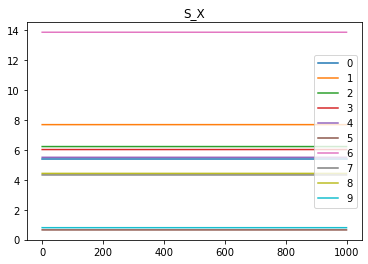

In [275]:
for i in range(0,10):
    print(np.array(chi).shape)
    plt.plot(params[:,i,-1],label=str(i))
plt.legend()
plt.title('S_X')

(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)
(1000, 100, 1)


Text(0.5, 1.0, 't0')

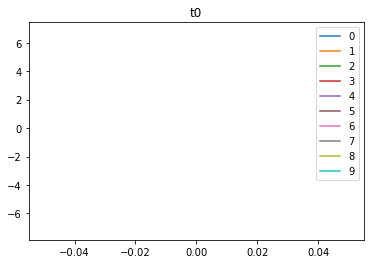

In [276]:
for i in range(10):
    print(np.array(chi).shape)
    plt.plot(params[:,i,0],label=str(i))
plt.legend()
plt.title('t0')

In [238]:
theta_r = ev_params[10:110,0]/180*math.pi


Text(0.5, 1.0, 'theta')

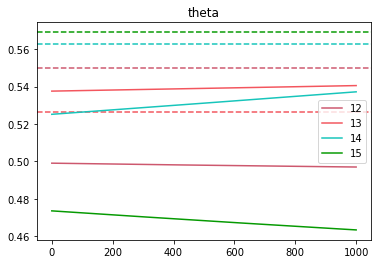

In [239]:
for i in range(12,16):
    c=np.random.rand(3)
    plt.plot(params[:,i,1],label=str(i),c=c)
    plt.axhline(y = theta_r[i], color =c, linestyle = '--') 
plt.legend()
plt.title('theta')

Text(0.5, 1.0, 'phi')

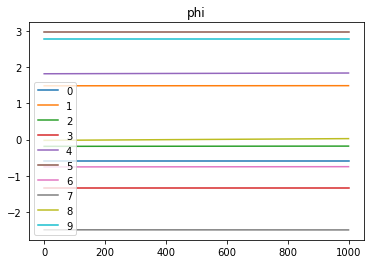

In [240]:
for i in range(10):
    plt.plot(params[:,i,2],label=str(i))
plt.legend()
plt.title('phi')

(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)
(1001, 100, 7)


Text(0.5, 1.0, 'courve')

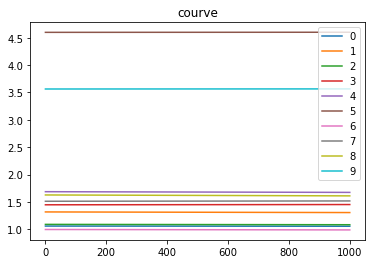

In [241]:
for i in range(10):
    print(params[:].shape)
    plt.plot(params[:,i,3],label=str(i))
plt.legend()
plt.title('courve')

In [242]:
ev_params[10:110][:20]

array([[ 35.6531 , 325.147  ],
       [ 30.5317 , 117.835  ],
       [ 34.0435 , 355.499  ],
       [ 31.3505 , 283.593  ],
       [ 32.8267 , 141.962  ],
       [ 30.6234 , 173.66   ],
       [ 33.6671 , 353.896  ],
       [ 32.0517 , 227.489  ],
       [ 34.2791 ,  21.6844 ],
       [ 31.4452 , 161.245  ],
       [ 32.5382 , 129.853  ],
       [ 30.9973 ,   1.58276],
       [ 31.5078 , 184.606  ],
       [ 30.1544 , 166.44   ],
       [ 32.2389 , 340.869  ],
       [ 32.6002 , 148.7    ],
       [ 30.889  ,  40.8346 ],
       [ 32.8004 , 277.232  ],
       [ 32.5794 , 332.339  ],
       [ 29.9132 , 101.336  ]], dtype=float32)

In [243]:
ang_res=tf.concat([rec.theta*180/3.14,tf.where(rec.phi*180/3.14>0,rec.phi*180/3.14,(rec.phi+3.14*2)*180/3.14)],axis=1)
ang_res[:20]

<tf.Tensor: shape=(20, 2), dtype=float32, numpy=
array([[ 42.613438 , 326.519    ],
       [ 29.967262 ,  85.194786 ],
       [ 38.413326 , 349.689    ],
       [ 30.077446 , 283.50916  ],
       [ 21.98254  , 105.17758  ],
       [ 27.183039 , 169.62624  ],
       [ 27.151308 , 317.1786   ],
       [ 34.417263 , 217.24104  ],
       [ 32.982697 ,   1.5054728],
       [ 33.8068   , 159.28044  ],
       [ 20.028587 , 139.48233  ],
       [ 33.921844 ,   1.186051 ],
       [ 28.491514 , 174.32364  ],
       [ 30.98405  , 159.70172  ],
       [ 30.792974 , 332.6076   ],
       [ 26.566174 , 156.69312  ],
       [ 33.95011  ,  34.503517 ],
       [ 26.344395 , 291.76743  ],
       [ 28.929094 , 320.88574  ],
       [ 29.854656 ,  93.10046  ]], dtype=float32)>

In [244]:
rub_theta = ev_params[10:110,0]
my_theta = ang_res[:,0]
info = tf.concat([tf.expand_dims(rub_theta,1),tf.expand_dims(my_theta,1),tf.expand_dims(my_theta-rub_theta,1)],1)
info

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 35.6531    ,  42.613438  ,   6.9603386 ],
       [ 30.5317    ,  29.967262  ,  -0.56443787],
       [ 34.0435    ,  38.413326  ,   4.3698273 ],
       [ 31.3505    ,  30.077446  ,  -1.2730541 ],
       [ 32.8267    ,  21.98254   , -10.844158  ],
       [ 30.6234    ,  27.183039  ,  -3.440361  ],
       [ 33.6671    ,  27.151308  ,  -6.515791  ],
       [ 32.0517    ,  34.417263  ,   2.3655624 ],
       [ 34.2791    ,  32.982697  ,  -1.296402  ],
       [ 31.4452    ,  33.8068    ,   2.3616009 ],
       [ 32.5382    ,  20.028587  , -12.509613  ],
       [ 30.9973    ,  33.921844  ,   2.9245453 ],
       [ 31.5078    ,  28.491514  ,  -3.016285  ],
       [ 30.1544    ,  30.98405   ,   0.8296509 ],
       [ 32.2389    ,  30.792974  ,  -1.4459248 ],
       [ 32.6002    ,  26.566174  ,  -6.034027  ],
       [ 30.889     ,  33.95011   ,   3.0611115 ],
       [ 32.8004    ,  26.344395  ,  -6.456005  ],
       [ 32.5794    ,  28.929094

In [245]:
#Befor chi_L
diff= tf.reduce_mean(tf.math.abs(ev_params[10:110] -ang_res),axis=0)
print(diff)
print(tf.math.reduce_std(ev_params[10:110,0] -ang_res[:,0]),tf.math.reduce_std(ev_params[10:110,1] -ang_res[:,1]))

tf.Tensor([ 3.6680355 34.19594  ], shape=(2,), dtype=float32)
tf.Tensor(4.7162614, shape=(), dtype=float32) tf.Tensor(89.470856, shape=(), dtype=float32)


In [164]:
rec_0 = Reconstruction(data[10:110],tf.float32)
rec_0.place_params()

In [247]:
# phi problem
rub_phi = ev_params[10:110,1]
my_phi = ang_res[:,1]
real_phi = tf.cast(real_ang[10:110,1],tf.float32)
print(rub_phi.shape,my_phi.shape)

(100,) (100,)


In [248]:
real_phi.dtype

tf.float32

In [249]:
# rubsov loss
info = tf.concat([tf.expand_dims(rub_phi,1),tf.expand_dims(real_phi,1),tf.expand_dims(real_phi-rub_phi,1)],1)
info

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 325.147     ,  323.625     ,   -1.5220032 ],
       [ 117.835     ,  117.254     ,   -0.5810013 ],
       [ 355.499     ,  355.848     ,    0.34899902],
       [ 283.593     ,  283.808     ,    0.21502686],
       [ 141.962     ,  143.354     ,    1.3919983 ],
       [ 173.66      ,  174.618     ,    0.95799255],
       [ 353.896     ,  357.138     ,    3.2420044 ],
       [ 227.489     ,  218.874     ,   -8.6150055 ],
       [  21.6844    ,   20.1942    ,   -1.4902    ],
       [ 161.245     ,  154.829     ,   -6.4160004 ],
       [ 129.853     ,  134.927     ,    5.074005  ],
       [   1.58276   ,    3.57281   ,    1.99005   ],
       [ 184.606     ,  186.847     ,    2.2409973 ],
       [ 166.44      ,  150.76      ,  -15.680008  ],
       [ 340.869     ,  346.152     ,    5.28302   ],
       [ 148.7       ,  152.153     ,    3.453003  ],
       [  40.8346    ,   39.8145    ,   -1.0200996 ],
       [ 277.232     ,  277.253 

In [250]:
info = tf.concat([tf.expand_dims(rub_phi,1),tf.expand_dims(my_phi,1),tf.expand_dims(my_phi-rub_phi,1)],1)
info

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 325.147     ,  326.519     ,    1.3720093 ],
       [ 117.835     ,   85.194786  ,  -32.640213  ],
       [ 355.499     ,  349.689     ,   -5.8099976 ],
       [ 283.593     ,  283.50916   ,   -0.08383179],
       [ 141.962     ,  105.17758   ,  -36.784424  ],
       [ 173.66      ,  169.62624   ,   -4.0337677 ],
       [ 353.896     ,  317.1786    ,  -36.717407  ],
       [ 227.489     ,  217.24104   ,  -10.247955  ],
       [  21.6844    ,    1.5054728 ,  -20.178928  ],
       [ 161.245     ,  159.28044   ,   -1.9645538 ],
       [ 129.853     ,  139.48233   ,    9.6293335 ],
       [   1.58276   ,    1.186051  ,   -0.39670897],
       [ 184.606     ,  174.32364   ,  -10.282364  ],
       [ 166.44      ,  159.70172   ,   -6.7382812 ],
       [ 340.869     ,  332.6076    ,   -8.261383  ],
       [ 148.7       ,  156.69312   ,    7.9931183 ],
       [  40.8346    ,   34.503517  ,   -6.3310814 ],
       [ 277.232     ,  291.7674

In [157]:
np.set_printoptions(suppress=True)
info[:,2]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([   2.111908  ,  -33.523155  ,   -5.7290344 ,    0.8772583 ,
        -38.469826  ,   -5.173401  ,  -35.588135  ,  -10.035873  ,
        -21.532997  ,   -3.25766   ,    8.585297  ,    0.14750206,
        -11.338928  ,   -7.412979  ,   -8.156464  ,    7.6427    ,
         -7.038189  ,   15.857697  ,  -10.887634  ,   -8.491959  ,
        -13.300346  ,   29.111115  ,  -24.053001  ,   33.634544  ,
        -81.61104   , -351.9647    , -326.15024   ,   -1.7060852 ,
        346.81488   ,   -2.1841812 ,   16.569153  ,  -25.334763  ,
         13.284729  ,   -5.842087  ,  -34.011475  ,  -38.414303  ,
        -13.23465   ,   17.655657  , -270.53946   ,  -36.554123  ,
        -54.05065   , -337.72552   ,  -74.88132   ,  -47.64084   ,
          6.9416137 ,  -21.464981  ,   12.658455  ,    0.61016846,
          1.8561249 ,   -8.032883  ,    4.320175  ,   -0.3751831 ,
          2.011322  ,   -2.7417374 ,   -3.7217102 ,    3.7148438 ,
          4.25

In [166]:
phi_0 = rec_0.phi * 180/pi
# phi_0

In [165]:
info_0 = tf.concat([tf.expand_dims(rub_phi,1),tf.expand_dims(phi_0,1),tf.expand_dims(phi_0-rub_phi,1)],1)
info_0

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 325.147     ,  -33.339085  , -358.48608   ],
       [ 117.835     ,   84.94911   ,  -32.885887  ],
       [ 355.499     ,  -10.6808605 , -366.17984   ],
       [ 283.593     ,  -76.317474  , -359.91046   ],
       [ 141.962     ,  103.96337   ,  -37.998634  ],
       [ 173.66      ,  169.54025   ,   -4.119751  ],
       [ 353.896     ,  -43.18503   , -397.08102   ],
       [ 227.489     , -142.50192   , -369.9909    ],
       [  21.6844    ,   -1.2376478 ,  -22.922049  ],
       [ 161.245     ,  159.10197   ,   -2.1430206 ],
       [ 129.853     ,  139.70854   ,    9.855545  ],
       [   1.58276   ,    1.5303783 ,   -0.05238163],
       [ 184.606     ,  174.16695   ,  -10.439056  ],
       [ 166.44      ,  159.41281   ,   -7.027191  ],
       [ 340.869     ,  -27.761467  , -368.63046   ],
       [ 148.7       ,  156.59326   ,    7.893265  ],
       [  40.8346    ,   32.994385  ,   -7.840214  ],
       [ 277.232     ,  -68.2030

In [169]:
print(tf.concat([info[:,2:],info_0[:,2:]],1))

tf.Tensor(
[[   2.111908   -358.48608   ]
 [ -33.523155    -32.885887  ]
 [  -5.7290344  -366.17984   ]
 [   0.8772583  -359.91046   ]
 [ -38.469826    -37.998634  ]
 [  -5.173401     -4.119751  ]
 [ -35.588135   -397.08102   ]
 [ -10.035873   -369.9909    ]
 [ -21.532997    -22.922049  ]
 [  -3.25766      -2.1430206 ]
 [   8.585297      9.855545  ]
 [   0.14750206   -0.05238163]
 [ -11.338928    -10.439056  ]
 [  -7.412979     -7.027191  ]
 [  -8.156464   -368.63046   ]
 [   7.6427        7.893265  ]
 [  -7.038189     -7.840214  ]
 [  15.857697   -345.4351    ]
 [ -10.887634   -371.3482    ]
 [  -8.491959     -8.344208  ]
 [ -13.300346    -12.482742  ]
 [  29.111115   -331.57324   ]
 [ -24.053001    -24.379665  ]
 [  33.634544     34.091812  ]
 [ -81.61104     -81.77302   ]
 [-351.9647     -352.6139    ]
 [-326.15024    -326.2939    ]
 [  -1.7060852  -362.39197   ]
 [ 346.81488     -13.4753275 ]
 [  -2.1841812    -1.9374847 ]
 [  16.569153     16.626709  ]
 [ -25.334763    -25.649082 